In [1]:
import torch
import torch.nn as nn 
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Make sure to update where the MNIST dataset is being downloaded to
DATA_PATH = "~/Research/data" 

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

training_data = datasets.MNIST(
    root=DATA_PATH,            
    train=True,            
    download=True,          
    transform=transform    
)
test_data = datasets.MNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=transform 
)

train_dataloader = DataLoader(training_data,    # our dataset
                              batch_size=64,    # batch size
                              shuffle=True      # shuffling the data
                            )
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits    

device = "cuda"

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

# create helper function to show distribution of model parameters 
import matplotlib.pyplot as plt 
import numpy as np 

def param_hist(model:nn.Module, model_name:str) -> None: 
    res = [] 
    for name, param in model.named_parameters(): 
        res += torch.flatten(param.data).tolist()
        
    plt.hist(res, bins=np.linspace(min(res) -0.1, max(res) + 0.1, 100))
    plt.title(f"Histogram of Parameter Distribution of {model_name}")
    plt.show() 


In [2]:
def run(model): 
    accs = [] 
    model = model.cuda()

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        model.parameters(),     # which parameters to optimize
        lr=1e-3,                 # learning rate 
        momentum=0.9
    )
    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        acc = test(test_dataloader, model, loss_fn)
        accs.append(acc)
    return accs

First, we experiment by loading all parameters with $0$ or $1$s. 

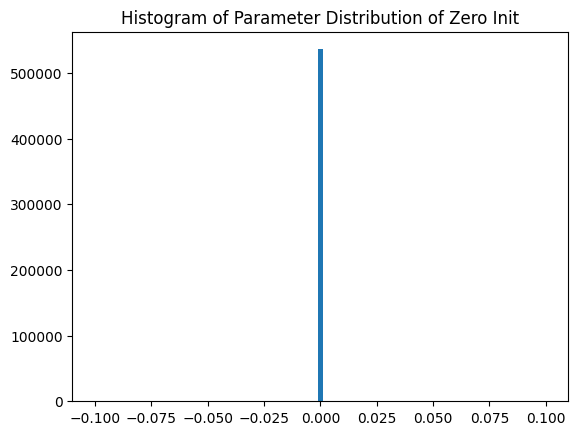

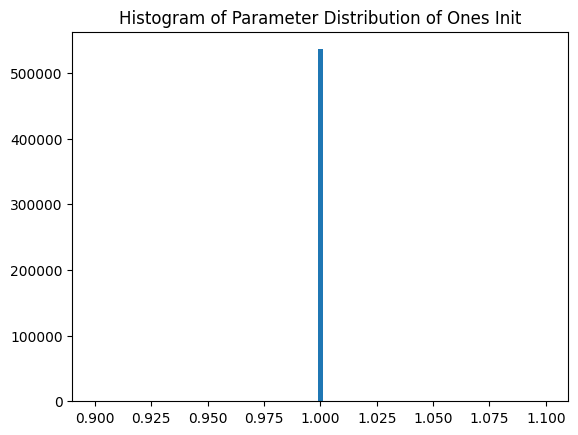

In [3]:
model_zero_init = NeuralNetwork()
for name, param in model_zero_init.named_parameters(): 
    param.data = torch.zeros_like(param.data)
    
model_ones_init = NeuralNetwork()
for name, param in model_ones_init.named_parameters(): 
    param.data = torch.ones_like(param.data)

param_hist(model_zero_init, "Zero Init") 
param_hist(model_ones_init, "Ones Init") 

In [5]:
zero_init_acc = run(model_zero_init)
ones_init_acc = run(model_ones_init)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301034 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301102 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301052 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.300923 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301035 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301033 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.300976 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301089 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301022 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.301150 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg los

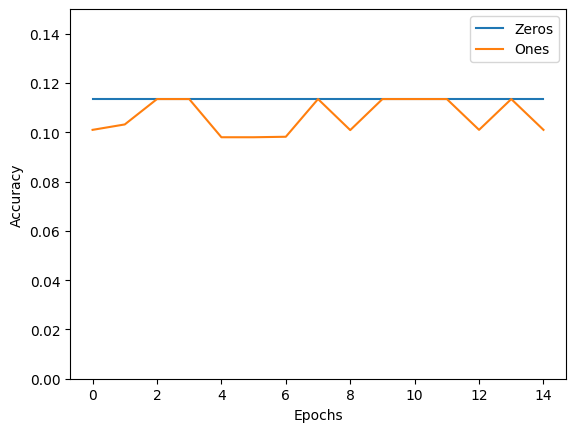

In [7]:
plt.plot(zero_init_acc, label="Zeros") 
plt.plot(ones_init_acc, label="Ones") 
plt.legend() 
plt.ylabel("Accuracy") 
plt.xlabel("Epochs")
plt.ylim(0, 0.15)
plt.show()

In [10]:
model_bernoulli_1_init = NeuralNetwork() 
for name, param in model_bernoulli_1_init.named_parameters(): 
    param.data = torch.where(param.data < 0.0, 1.0, -1.0)

model_gauss_1_init = NeuralNetwork() 
for name, param in model_gauss_1_init.named_parameters(): 
    param.data = torch.randn_like(param.data) 
    
model_uniform_1_init = NeuralNetwork() 
for name, param in model_uniform_1_init.named_parameters(): 
    param.data = torch.rand_like(param.data) * 2 - 1 


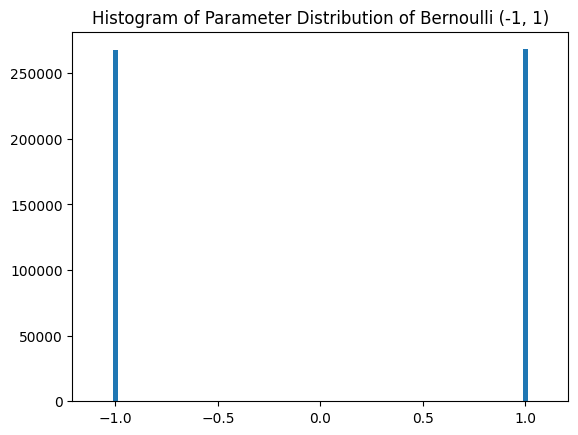

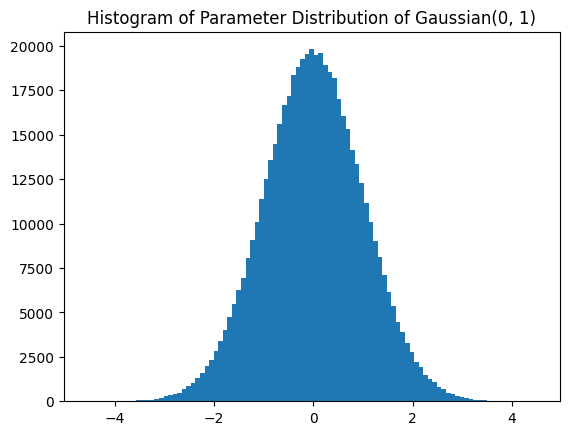

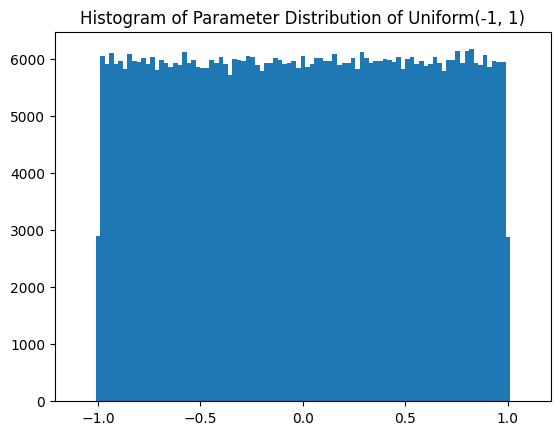

In [11]:
param_hist(model_bernoulli_1_init, "Bernoulli (-1, 1)") 
param_hist(model_gauss_1_init, "Gaussian(0, 1)")
param_hist(model_uniform_1_init, "Uniform(-1, 1)")

In [12]:
bernoulli_1_init_acc = run(model_bernoulli_1_init) 
gauss_init_acc = run(model_gauss_1_init) 
uniform_init_acc = run(model_uniform_1_init)

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 16.0%, Avg loss: 2.472459 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 17.9%, Avg loss: 2.409574 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 20.5%, Avg loss: 2.274751 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 26.5%, Avg loss: 2.282322 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 28.1%, Avg loss: 2.254701 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 30.5%, Avg loss: 2.207404 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 31.3%, Avg loss: 2.127704 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 35.8%, Avg loss: 2.081472 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 37.3%, Avg loss: 2.058820 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 35.3%, Avg loss: 1.940934 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 37.4%, Avg los

TypeError: _AxesBase.set_ylim() takes from 1 to 3 positional arguments but 4 were given

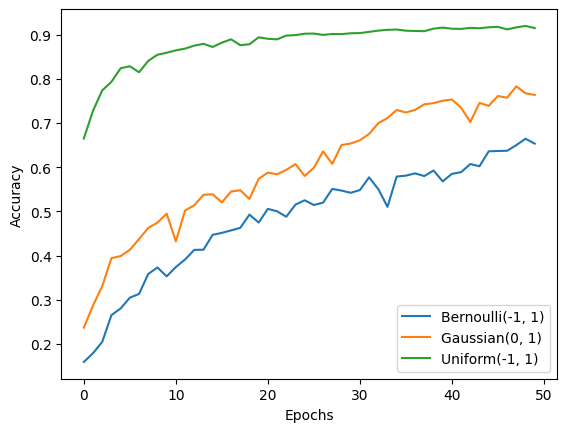

In [15]:
plt.plot(bernoulli_1_init_acc, label="Bernoulli(-1, 1)") 
plt.plot(gauss_init_acc, label="Gaussian(0, 1)") 
plt.plot(uniform_init_acc, label="Uniform(-1, 1)") 
plt.legend() 
plt.ylabel("Accuracy") 
plt.xlabel("Epochs")
plt.ylim(0, 1, 0.1)
plt.show()


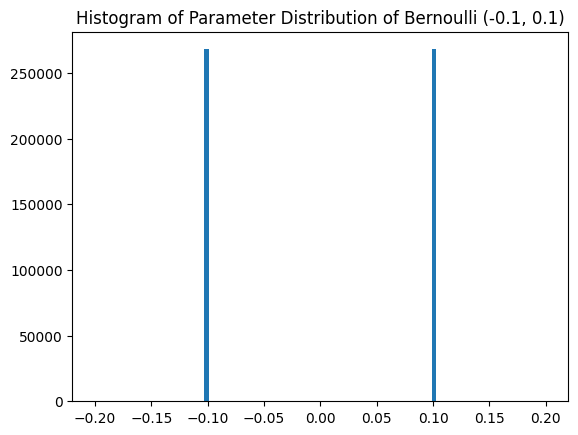

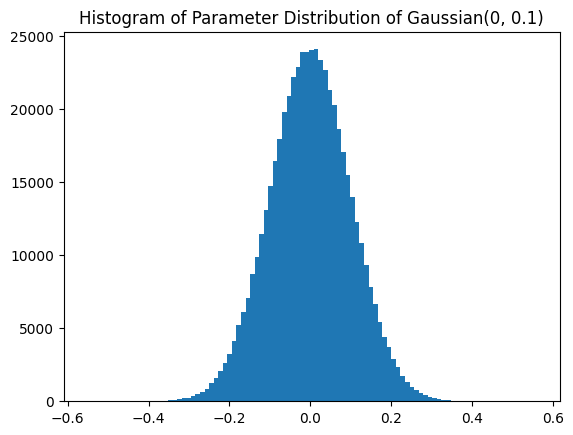

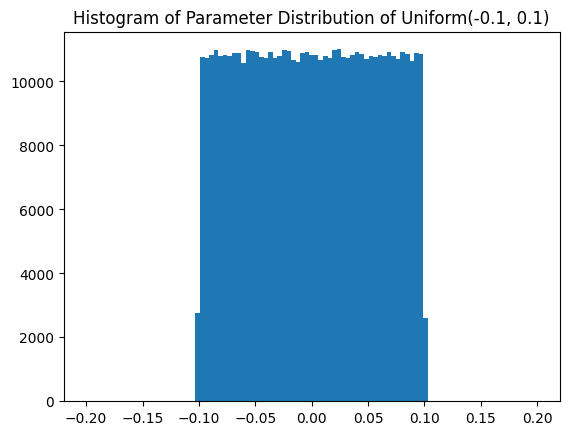

In [20]:
model_bernoulli_01_init = NeuralNetwork() 
for name, param in model_bernoulli_01_init.named_parameters(): 
    param.data = torch.where(param.data < 0.0, 0.1, -0.1)

model_gauss_01_init = NeuralNetwork() 
for name, param in model_gauss_01_init.named_parameters(): 
    param.data = torch.randn_like(param.data) * 0.1 
    
model_uniform_01_init = NeuralNetwork() 
for name, param in model_uniform_01_init.named_parameters(): 
    param.data = torch.rand_like(param.data) * 0.2 - 0.1
   
param_hist(model_bernoulli_01_init, "Bernoulli (-0.1, 0.1)") 
param_hist(model_gauss_01_init, "Gaussian(0, 0.1)")
param_hist(model_uniform_01_init, "Uniform(-0.1, 0.1)") 

In [21]:
bernoulli_01_init_acc = run(model_bernoulli_01_init) 
gauss_01_init_acc = run(model_gauss_01_init) 
uniform_01_init_acc = run(model_uniform_01_init)    

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.278850 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.212754 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.180225 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.161225 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.153426 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.145972 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.128450 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.132895 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.119084 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.112590 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 96.5%, Avg los

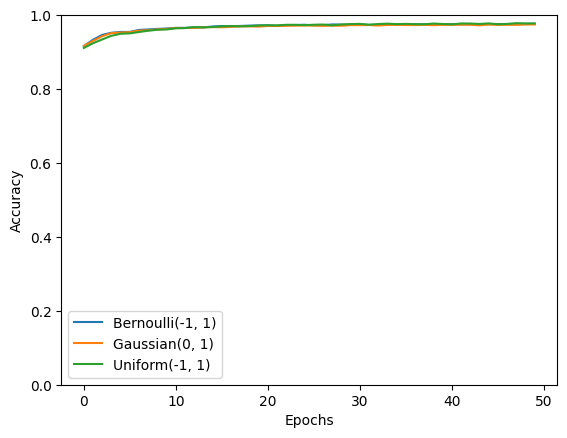

In [24]:
plt.plot(bernoulli_01_init_acc, label="Bernoulli(-1, 1)") 
plt.plot(gauss_01_init_acc, label="Gaussian(0, 1)") 
plt.plot(uniform_01_init_acc, label="Uniform(-1, 1)") 
plt.legend() 
plt.ylabel("Accuracy") 
plt.xlabel("Epochs")
plt.ylim(0, 1.0)
plt.show()
